In [1]:
import numpy as np
import pandas as pd 
import os
from matplotlib import pyplot as plt 
import seaborn as sns
import nltk
import re
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras import Sequential, layers, preprocessing
import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('Big_AHR.csv', index_col=0)
df = df[df.label != 3] 
df.head()

,title,rating,review_text,location,hotel,label
0,Excelente y personal amable,5,Un hotel muy bueno. El personal fue muy amabl...,Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1
1,Céntrico,4,"Muy buen hotel al nivel de lo esperado, habita...",Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1
2,Hotel excepcional,5,Magnífico hotel. La verdad es que todo perfect...,Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1
3,WOW!!,5,"Hotel hermoso, buen diseño, original, limpio. ...",Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1
4,Magnifico,5,Magnífica ubicación en pleno centro de Sevilla...,Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1


In [3]:
# some useful functions to eliminate the noise from texts and measure sequence length
def clean_text(text):
    return re.sub('[^A-Za-z0-9áéíóú]', ' ', text.lower())


def seq_len(text):
    return len(text.split(' '))

In [4]:
df.review_text = df.review_text.apply(lambda x: clean_text(x))
df['len'] = df.review_text.apply(lambda x: seq_len(x))
df.head()

,title,rating,review_text,location,hotel,label,len
0,Excelente y personal amable,5,un hotel muy bueno el personal fue muy amabl...,Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1,53
1,Céntrico,4,muy buen hotel al nivel de lo esperado habita...,Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1,47
2,Hotel excepcional,5,magnífico hotel la verdad es que todo perfect...,Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1,46
3,WOW!!,5,hotel hermoso buen dise o original limpio ...,Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1,41
4,Magnifico,5,magnífica ubicación en pleno centro de sevilla...,Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1,45


In [5]:
print('Maximum sequence length is', df.len.max())
print('Minimum sequence length is', df.len.min())
print('Average sequence length is', df.len.mean())

Maximum sequence length is 1134
Minimum sequence length is 11
Average sequence length is 90.79852811674425


In [6]:
from sklearn.model_selection import train_test_split
X = np.array(df['review_text'])
y = np.array(df['label'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=327)

print('Train set contains {} entries'.format(len(X_train)))
print("Test set contains {} entries".format(len(y_test)))

Train set contains 12718 entries
Test set contains 3180 entries


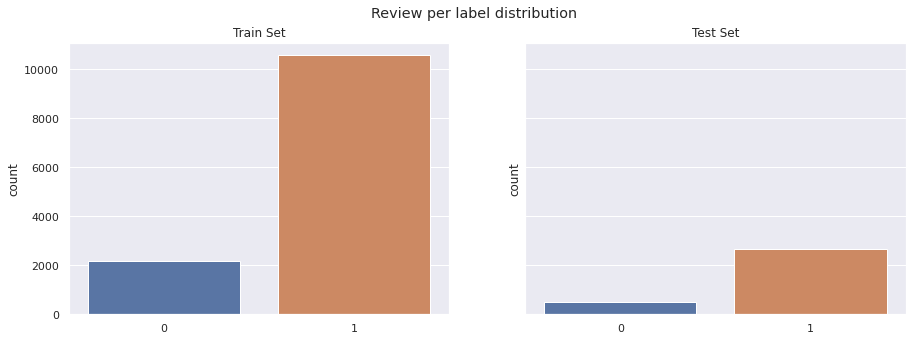

In [7]:
sns.set_theme(style="darkgrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Review per label distribution')
ax1 = sns.countplot(x=y_train, ax=ax1)
ax1.set_title('Train Set')
ax2 = sns.countplot(x=y_test, ax=ax2)
ax2.set_title('Test Set')
plt.show()

In [8]:
num_words = 28000 # the numer of words to tokenize 
max_seq = 300 # maximum sequence size

# fit the tokenizer on trainig texts
tokenizer = preprocessing.text.Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

# Dictionary of words ordered in terms of their frequency 
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

print(f" {vocab_size-1} unique tokens found")
print(list(word_index)[:10])

 27660 unique tokens found
['de', 'y', 'la', 'el', 'que', 'en', 'a', 'muy', 'un', 'con']


In [9]:
print("Original phrase:\n", X_train[0])
print()

# Turn the phrases into their numerical equivalents 
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
print('Phrase as sequence:', X_train_seq[0])
print()

# Padding of our sequences 
X_train_processed = preprocessing.sequence.pad_sequences(X_train_seq, padding='post', maxlen=max_seq)
X_test_processed = preprocessing.sequence.pad_sequences(X_test_seq, padding='post', maxlen=max_seq)
print('Padded sequence:', X_train_processed[0])

Original phrase:
 estuvimos el pasado fin de semana  24 al 26 de agosto    todo fueron atenciones y buena disposición por parte de todo el personal de recepción para solucionar un problema que llevabamos  muy buenas y espaciosas las habitaciones  perfecta la situacion  tanto para la playa como para el casco antiguo  agradable todo el personal  en fin siempre que vuelva a cadiz  no dudaré en volverme a hospedar en este hotel  al mismo tiempo que lo recomendará a los amigos  gracias por todo 

Phrase as sequence: [148, 4, 283, 151, 1, 124, 965, 25, 3249, 1, 695, 23, 356, 1685, 2, 43, 1298, 17, 156, 1, 23, 4, 29, 1, 64, 14, 1958, 9, 232, 5, 7592, 8, 249, 2, 779, 15, 30, 174, 3, 1457, 133, 14, 3, 247, 33, 14, 4, 452, 317, 78, 23, 4, 29, 6, 151, 122, 5, 1189, 7, 3057, 12, 3941, 6, 12906, 7, 7593, 6, 36, 16, 25, 198, 223, 5, 18, 10403, 7, 20, 357, 121, 17, 23]

Padded sequence: [  148     4   283   151     1   124   965    25  3249     1   695    23
   356  1685     2    43  1298    17   156

In [10]:
os.chdir('/kaggle/input/pretrained-word-vectors-for-spanish')
embedding_index = {}
with open("SBW-vectors-300-min5.txt") as f:
  for line in f:
    word, coef = line.split(maxsplit=1)
    coef = np.fromstring(coef, 'f', sep=' ')
    embedding_index[word] = coef 
print('{} embeddings found'.format(len(embedding_index)))

1000654 embeddings found


In [11]:
embedding_dim = 300
hits = 0 
misses = 0

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for w, i in word_index.items():
  embedding_vector = embedding_index.get(word)
  if embedding_vector is not None:
    hits+=1
    embedding_matrix[i] = embedding_vector
  else:
    misses += 1

print('{} words encoded with an embedding from SBW-vectors'.format(hits))
print('{} word embeddings not found'.format(misses))

27660 words encoded with an embedding from SBW-vectors
0 word embeddings not found


In [12]:
model = Sequential()

model.add(
    layers.Embedding(input_dim=vocab_size,
                     embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                     mask_zero=True,
                     output_dim=embedding_dim, # dimension of dense embedding. 
                     input_length=max_seq)
)

model.add(layers.LSTM(128))

model.add(layers.Dense(units=1, activation='sigmoid'))

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

2021-12-11 18:41:08.580419: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-11 18:41:08.708167: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-11 18:41:08.709366: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-11 18:41:08.712175: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          8298300   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 8,518,077
Trainable params: 8,518,077
Non-trainable params: 0
_________________________________________________________________


In [13]:
with tf.device('/gpu:0'):
    history = model.fit(
    x=X_train_processed,
    y=y_train,
    epochs=10, 
    batch_size=128
)

2021-12-11 18:41:12.777011: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2021-12-11 18:41:17.559280: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


100/100 [==============================] - 14s 81ms/step - loss: 0.3394 - accuracy: 0.8630
Epoch 2/10
100/100 [==============================] - 8s 79ms/step - loss: 0.1017 - accuracy: 0.9643
Epoch 3/10
100/100 [==============================] - 8s 79ms/step - loss: 0.0370 - accuracy: 0.9904
Epoch 4/10
100/100 [==============================] - 7s 75ms/step - loss: 0.0228 - accuracy: 0.9937
Epoch 5/10
100/100 [==============================] - 8s 80ms/step - loss: 0.0207 - accuracy: 0.9949
Epoch 6/10
100/100 [==============================] - 8s 76ms/step - loss: 0.0122 - accuracy: 0.9959
Epoch 7/10
100/100 [==============================] - 8s 77ms/step - loss: 0.0077 - accuracy: 0.9978
Epoch 8/10
100/100 [==============================] - 7s 75ms/step - loss: 0.0025 - accuracy: 0.9991
Epoch 9/10
100/100 [==============================] - 8s 82ms/step - loss: 0.0056 - accuracy: 0.9983
Epoch 10/10
100/100 [==============================] - 8s 80ms/step - loss: 0.0447 - accuracy: 0.9855

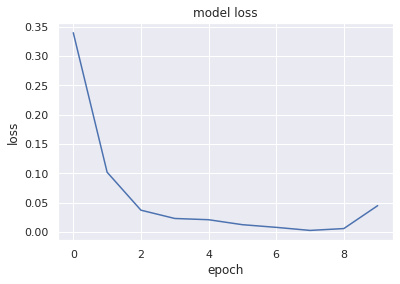

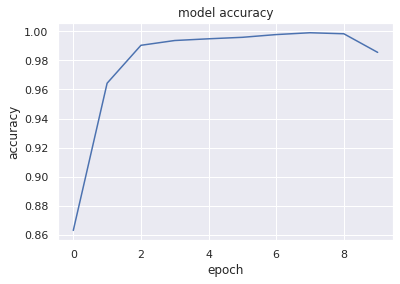

In [14]:
# Loss plot
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Accuracy plot
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

In [15]:
y_pred = model.predict(x=X_test_processed, batch_size=128)
y_pred = [0 if y < 0.5 else 1 for y in y_pred]

print(classification_report(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89       515
           1       0.99      0.97      0.98      2665

    accuracy                           0.96      3180
   macro avg       0.91      0.95      0.93      3180
weighted avg       0.96      0.96      0.96      3180

Accuracy: 0.960691823899371


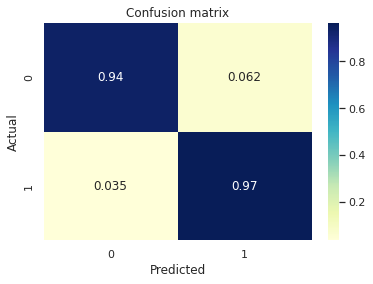

In [16]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True, cmap="YlGnBu")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.show()